In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from itertools import cycle


def roc_plot(y_test, y_pred):

    rice = {
        0: 'Cammeo',
        1: 'Osmanscik',
    }

    plt.figure(figsize=(8, 4))

    colors = cycle(['red', 'blue'])

    for i, class_name in rice.items():
        y_test_class = [1 if label == i else 0 for label in y_test]
        y_pred_class = [pred[i] for pred in y_pred]

        fpr, tpr, _ = roc_curve(y_test_class, y_pred_class)
        roc_auc = auc(fpr, tpr)

        color = next(colors)

        plt.subplot(1, len(rice), i + 1)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC curve (area = {roc_auc:.2f})')
        plt.xlim([-.05, 1.05])
        plt.ylim([.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {class_name}')
        plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


def cm_plot(conf_matrix):
    rice = ['Cammeo', 'Osmanscik']

    plt.figure(figsize=(8, 4))
    sns.heatmap(conf_matrix, cmap='Blues', annot=True, fmt='d',
                xticklabels=rice, yticklabels=rice)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [210]:
import numpy as np
import pandas as pd

cols = ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length',
        'Eccentricity', 'Convex_Area', 'Extent', 'Class']

data = pd.read_csv('./data/Rice_Cammeo_Osmancik.arff', names=cols)
data['Class'] = (data['Class'] == 'Osmancik').astype(int)

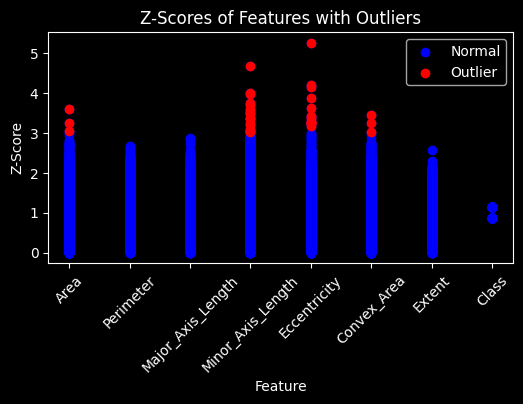

In [211]:
fig, ax = plt.subplots(figsize=(6,  3))

z_scores = np.abs((data.select_dtypes(include=[np.number]) - data.select_dtypes(
    include=[np.number]).mean()) / data.select_dtypes(include=[np.number]).std())
outliers = z_scores > 3

for i, col in enumerate(z_scores.columns):
    # Blue Z-Score
    ax.scatter([col]*len(z_scores), z_scores[col],
               c='b', label='Normal' if i == 0 else "")

    # Red Z-Score
    outlier_z_scores = z_scores.loc[outliers[col], col]

    ax.scatter([col]*len(outlier_z_scores), outlier_z_scores,
               c='r', label='Outlier' if i == 0 else "")

ax.set_title('Z-Scores of Features with Outliers')
ax.set_xlabel('Feature')
ax.set_ylabel('Z-Score')
ax.legend()
plt.xticks(rotation=45)
plt.show()

In [212]:
from sklearn.preprocessing import StandardScaler

x = data.iloc[:, 0:7].values
y = data.iloc[:, -1]

scaler = StandardScaler()
x = scaler.fit_transform(x)

In [213]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.3)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=.15)

cat_model = CatBoostClassifier(iterations=250, max_depth=10,
                               min_child_samples=25, learning_rate=0.085, task_type='GPU', verbose=0)

cat_model.fit(x_train, y_train, eval_set=(x_val, y_val))

y_pred = cat_model.predict(x_test)
y_prob = cat_model.predict_proba(x_test)

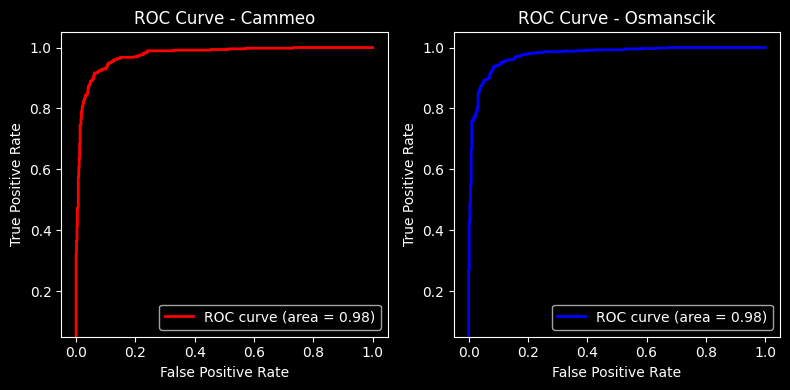

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       468
           1       0.94      0.94      0.94       675

    accuracy                           0.93      1143
   macro avg       0.92      0.93      0.92      1143
weighted avg       0.93      0.93      0.93      1143

[[427  41]
 [ 42 633]]


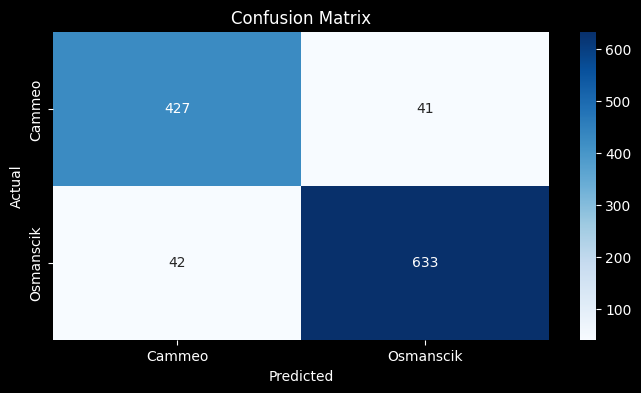

In [214]:
from sklearn.metrics import classification_report, confusion_matrix

roc_plot(y_test, y_prob)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
cm_plot(confusion_matrix(y_test, y_pred))